# Nonlinear Examples

We will examine some nonlinear examples on which the SOS decomposition method is applied.

In [46]:
# Set up the workspace
using SumOfSquares, JuMP, PolyJuMP, DynamicPolynomials, MultivariatePolynomials, Optim
using CSDP#, SCS
using Plots
gr()

include("../src/NormalSoS.jl")

include("../src/MinimumActionPath.jl")

include("../src/GeomMinActPath.jl")

Main.gMAM

## Maier-Stein model

The widely studied Maier-Stein model may offer either a pure gradient system or one for which an orthogonal decomposition does not exist.

In [54]:
# The Maier-Stein model
γ = 10.0;    μ = 1.0
@polyvar x[1:2]
F(X::Vector) = [X[1] - X[1]^3 - γ*X[1]X[2]^2;
                 -μ*(X[1]^2 + 1)X[2]]
f = F(x)
V = -0.5*x[1]^2 + 0.25*x[1]^4 + 0.5γ*x[2]^2 + 0.5γ*x[1]^2*x[2]^2
@time U = NormalSoS.normdecomp(f,x)

fg = -differentiate(U,x)
Fg(X::Vector) = [try coefficients(subs(fg[1],x[1]=>X[1], x[2]=>X[2]))[1] catch; 0 end;
                 try coefficients(subs(fg[2],x[1]=>X[1], x[2]=>X[2]))[1] catch; 0 end]
fc = f + differentiate(U,x)
Fc(X::Vector) = [try coefficients(subs(fc[1],x[1]=>X[1], x[2]=>X[2]))[1] catch; 0 end;
                 try coefficients(subs(fc[2],x[1]=>X[1], x[2]=>X[2]))[1] catch; 0 end]


Chosen basis as:
Monomial{true}[x₁⁴, x₁³x₂, x₁²x₂², x₁³, x₁²x₂, x₁x₂², x₁², x₁x₂, x₂², x₁, x₂, 1]


CSDP 6.2.0
Iter:  0 Ap: 0.00e+00 Pobj: -3.5527137e-15 Ad: 0.00e+00 Dobj:  0.0000000e+00 
Iter:  1 Ap: 6.87e-01 Pobj:  1.4367229e+00 Ad: 8.32e-01 Dobj:  2.5913054e+01 
Iter:  2 Ap: 7.36e-01 Pobj:  9.0809201e-01 Ad: 8.12e-01 Dobj:  4.4027308e+01 
Iter:  3 Ap: 6.97e-01 Pobj:  1.0429900e+00 Ad: 6.40e-01 Dobj:  4.5552553e+01 
Iter:  4 Ap: 7.61e-01 Pobj:  7.5931577e-01 Ad: 8.39e-01 Dobj:  2.3037825e+01 
Iter:  5 Ap: 7.65e-01 Pobj:  6.5084676e-01 Ad: 8.95e-01 Dobj:  1.0297010e+01 
Iter:  6 Ap: 8.99e-01 Pobj:  6.8254128e-01 Ad: 7.91e-01 Dobj:  4.3775586e+00 
Iter:  7 Ap: 9.34e-01 Pobj:  8.5826622e-01 Ad: 7.03e-01 Dobj:  2.3377961e+00 
Iter:  8 Ap: 9.30e-01 Pobj:  1.0056194e+00 Ad: 7.46e-01 Dobj:  1.4954138e+00 
Iter:  9 Ap: 5.02e-01 Pobj:  1.0560927e+00 Ad: 8.66e-01 Dobj:  1.2384082e+00 
Iter: 10 Ap: 6.84e-01 Pobj:  1.1261960e+00 Ad: 6.04e-01 Dobj:  1.2000523e+00 
Iter: 11 Ap: 9.93e-01 Pobj:  1.1562375e+00 Ad: 8.89e-01 Dobj:  1.1698412e+00 
Iter: 12 Ap: 1.00e+00 Pobj:  1.1624725e+00 Ad: 9.98e-


Stuck at edge of primal feasibility, giving up. 
Partial Success: SDP solved with reduced accuracy
Primal objective value: -9.9999997e-01 
Dual objective value: -1.0000663e+00 
Relative primal infeasibility: 1.06e-07 
Relative dual infeasibility: 7.00e-10 
Real Relative Gap: -2.21e-05 
XZ Relative Gap: 1.29e-09 
DIMACS error measures: 1.30e-07 0.00e+00 1.80e-09 0.00e+00 -2.21e-05 1.29e-09


Fc (generic function with 1 method)

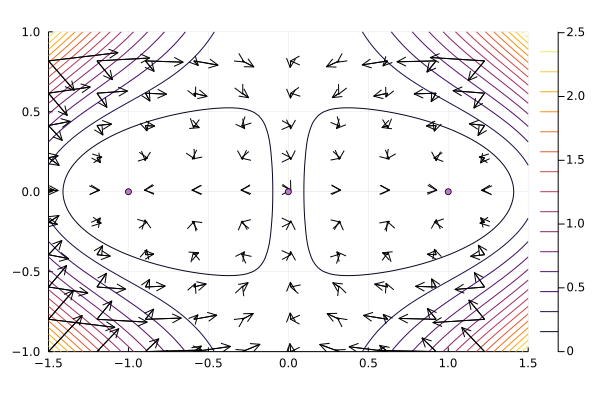

In [38]:
NormalSoS.plotlandscape(f, U, x, ([-1.5 1.5], [-1.0 1.0]), true)
plot!([-1 0 1]',[0 0 0]', line=0, marker=4, legend=false)

In [63]:
# Obtain the minimum action path
x₀ = [-1.0 0.0]  # Start point (row vector)
Tspan = 10.0  # Time span
N = 40
σ = 1.0
G(X::Vector) = σ*[1.0; 1.0]

dt = 0.02;    M=500

xₑ = [-0.4 0.0]
φ₀ = MAP.makepath(x₀,xₑ,N)
for ii=1:N-2
    φ₀[ii,2] = 0.1*randn()
end
resObj = MAP.optimalpath(F,G, x₀,xₑ, Tspan,N, φ₀)
φ₁ = [x₀; Optim.minimizer(resObj); xₑ]
ψ₁ = zeros(Float64,M,2)
ψ₁[1,:] = xₑ
for ii=2:M
    ψ₁[ii,:] = ψ₁[ii-1,:] + (-Fc(ψ₁[ii-1,:])+Fg(ψ₁[ii-1,:]))dt
end

xₑ = [-1.0 0.6]
φ₀ = MAP.makepath(x₀,xₑ,N)
resObj = MAP.optimalpath(F,G, x₀,xₑ, Tspan,N, φ₀)
φ₂ = [x₀; Optim.minimizer(resObj); xₑ]
ψ₂ = zeros(Float64,M,2)
ψ₂[1,:] = xₑ
for ii=2:M
    ψ₂[ii,:] = ψ₂[ii-1,:] + (-Fc(ψ₂[ii-1,:])+Fg(ψ₂[ii-1,:]))dt
end

Sm = gMAM.action(φ₁,F,G)
Ss = gMAM.action(reverse(ψ₁;dims=1),F,G)
Su = coefficients(subs(U,x[1]=>xₑ[1],x[2]=>xₑ[2]))[1] - coefficients(subs(U,x[1]=>x₀[1],x[2]=>x₀[2]))[1]
@show(Sm);    @show(Ss);    @show(Su)

Optimisation for T=10.00 gives S=0.28nothing
Optimisation is converged.
Optimisation for T=10.00 gives S=1.09

nothing
Optimisation is converged.


Sm = 0.1402341219057209
Ss = 0.1762272069971716
Su = 0.36091002419688567


0.36091002419688567

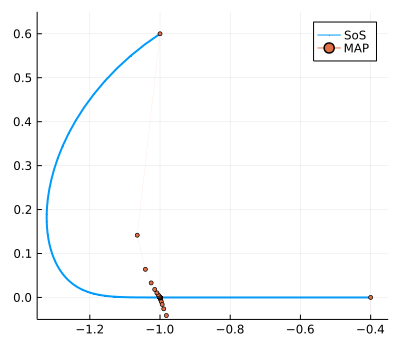

In [65]:
mapPlt = plot([ψ₁[:,1];reverse(ψ₂;dims=1)[:,1]],[ψ₁[:,2];reverse(ψ₂;dims=1)[:,2]], line=2, marker=0,label="SoS")
plot!(mapPlt, [φ₁[:,1];φ₂[:,1]],[φ₁[:,2];φ₂[:,2]], line=0, marker=3, label="MAP")
plot!(mapPlt, xlims=(-1.35,-0.35),ylims=(-0.05,0.65), size=(400,350))

### Quasipotential comparison

We now plot a comparison bewteen the true and SOS computed quasipotential along a line.

In [67]:
γ = 1.0;    μ = 1.0
@polyvar x[1:2]
F(X::Vector) = [X[1] - X[1]^3 - γ*X[1]X[2]^2;
                 -μ*(X[1]^2 + 1)X[2]]
f = F(x)
U = NormalSoS.normdecomp(f,x, CSDP.Optimizer,2)
fg = -differentiate(U,x)
Fg(X::Vector) = [try coefficients(subs(fg[1],x[1]=>X[1], x[2]=>X[2]))[1] catch; 0 end;
                 try coefficients(subs(fg[2],x[1]=>X[1], x[2]=>X[2]))[1] catch; 0 end]
fc = f + differentiate(U,x)
Fc(X::Vector) = [try coefficients(subs(fc[1],x[1]=>X[1], x[2]=>X[2]))[1] catch; 0 end;
                 try coefficients(subs(fc[2],x[1]=>X[1], x[2]=>X[2]))[1] catch; 0 end]

σ = 1.0
G(X::Vector) = σ*[1.0; 1.0]

Tspan = 10.0  # Time span
N = 400
x₀ = [-1.0 0.0]
dt = 0.02;    M=500

xVec = collect(-1.5:0.1:0.0)
Smx = zeros(length(xVec))
Ssx = zeros(length(xVec))
for (idx,xi) in enumerate(xVec)
    xₑ = [xi 0]
    φ₀ = MAP.makepath(x₀,xₑ,N)
    for ii=1:N-2
        φ₀[ii,2] = 0.1*randn()
    end
    
    # Find the optimal path and true action
    resObj = MAP.optimalpath(F,G, x₀,xₑ, Tspan,N, φ₀)
    φ = [x₀; Optim.minimizer(resObj); xₑ]
    Smx[idx] = gMAM.action(φ,F,G)
    
    # Compute the SOS predicted action
    ψ = zeros(Float64,M,2)
    ψ[1,:] = xₑ
    for ii=2:M
        ψ[ii,:] = ψ[ii-1,:] + (-Fc(ψ[ii-1,:])+Fg(ψ[ii-1,:]))dt
    end
    Ssx[idx] = gMAM.action(reverse(ψ;dims=1),F,G)
end

xVec = collect(-1.5:0.1:1.5)
Smy = zeros(length(xVec))
Ssy = zeros(length(xVec))
for (idx,xi) in enumerate(xVec)
    xₑ = [-1.0 xi]
    φ₀ = MAP.makepath(x₀,xₑ,N)
    for ii=1:N-2
        φ₀[ii,2] = 0.1*randn()
    end
    
    # Find the optimal path and true action
    resObj = MAP.optimalpath(F,G, x₀,xₑ, Tspan,N, φ₀)
    φ = [x₀; Optim.minimizer(resObj); xₑ]
    Smy[idx] = gMAM.action(φ,F,G)
    
    # Compute the SOS predicted action
    ψ = zeros(Float64,M,2)
    ψ[1,:] = xₑ
    for ii=2:M
        ψ[ii,:] = ψ[ii-1,:] + (-Fc(ψ[ii-1,:])+Fg(ψ[ii-1,:]))dt
    end
    Ssy[idx] = gMAM.action(reverse(ψ;dims=1),F,G)
end

Chosen basis as:
Monomial{true}[x₁⁴, x₁³x₂, x₁²x₂², x₁³, x₁²x₂, x₁x₂², x₁², x₁x₂, x₂², x₁, x₂, 1]


Iter: 14 Ap: 9.60e-01 Pobj: -7.1766898e-11 Ad: 9.58e-01 Dobj: -4.8284790e-09 
Success: SDP solved
Primal objective value: -7.1766898e-11 
Dual objective value: -4.8284790e-09 
Relative primal infeasibility: 2.22e-12 
Relative dual infeasibility: 1.58e-09 
Real Relative Gap: -4.76e-09 
XZ Relative Gap: 4.03e-09 
DIMACS error measures: 2.97e-12 0.00e+00 4.06e-09 0.00e+00 -4.76e-09 4.03e-09
CSDP 6.2.0
Iter:  0 Ap: 0.00e+00 Pobj: -3.5527137e-15 Ad: 0.00e+00 Dobj:  0.0000000e+00 
Iter:  1 Ap: 7.03e-01 Pobj:  2.0850142e+00 Ad: 8.26e-01 Dobj:  2.2829116e+01 
Iter:  2 Ap: 9.09e-01 Pobj:  3.9310376e-01 Ad: 7.95e-01 Dobj:  3.2277689e+01 
Iter:  3 Ap: 8.17e-01 Pobj:  4.0131128e-01 Ad: 8.79e-01 Dobj:  2.2769670e+01 
Iter:  4 Ap: 8.21e-01 Pobj:  4.4699460e-01 Ad: 9.24e-01 Dobj:  7.4032952e+00 
Iter:  5 Ap: 9.01e-01 Pobj:  5.7385209e-01 Ad: 8.68e-01 Dobj:  1.9179632e+00 
Iter:  6 Ap: 8.86e-01 Pobj:  1.0786589e+00 Ad: 6.82e-01 Dobj:  1.5172396e+00 
Iter:  7 Ap: 4.71e-01 Pobj:  1.1462600e+00 Ad: 5.03e

nothing
Optimisation is converged.


Optimisation for T=10.00 gives S=0.46nothing
Optimisation is converged.
Optimisation for T=10.00 gives S=0.24

nothing
Optimisation is converged.


Optimisation for T=10.00 gives S=0.10nothing
Optimisation is converged.
Optimisation for T=10.00 gives S=0.02

nothing
Optimisation is converged.


Optimisation for T=10.00 gives S=0.00nothing
Optimisation is converged.
Optimisation for T=10.00 gives S=0.02

nothing
Optimisation is converged.


Optimisation for T=10.00 gives S=0.06nothing
Optimisation is converged.
Optimisation for T=10.00 gives S=0.13

nothing
Optimisation is converged.


Optimisation for T=10.00 gives S=0.20nothing
Optimisation is converged.
Optimisation for T=10.00 gives S=0.28

nothing
Optimisation is converged.


Optimisation for T=10.00 gives S=0.35nothing
Optimisation is converged.
Optimisation for T=10.00 gives S=0.41

nothing
Optimisation is converged.


Optimisation for T=10.00 gives S=0.46nothing
Optimisation is converged.
Optimisation for T=10.00 gives S=0.49

nothing
Optimisation is converged.


Optimisation for T=10.00 gives S=0.50nothing
Optimisation is converged.
Optimisation for T=10.00 gives S=4.50

nothing
Optimisation is converged.


Optimisation for T=10.00 gives S=3.92nothing
Optimisation is converged.
Optimisation for T=10.00 gives S=3.38

nothing
Optimisation is converged.


Optimisation for T=10.00 gives S=2.88nothing
Optimisation is converged.
Optimisation for T=10.00 gives S=2.42

nothing
Optimisation is converged.


Optimisation for T=10.00 gives S=2.00nothing
Optimisation is converged.
Optimisation for T=10.00 gives S=1.62

nothing
Optimisation is converged.


Optimisation for T=10.00 gives S=1.28nothing
Optimisation is converged.
Optimisation for T=10.00 gives S=0.98

nothing
Optimisation is converged.


Optimisation for T=10.00 gives S=0.72nothing
Optimisation is converged.
Optimisation for T=10.00 gives S=0.50

nothing
Optimisation is converged.


Optimisation for T=10.00 gives S=0.32nothing
Optimisation is converged.
Optimisation for T=10.00 gives S=0.18

nothing
Optimisation is converged.


Optimisation for T=10.00 gives S=0.08nothing
Optimisation is converged.
Optimisation for T=10.00 gives S=0.02

nothing
Optimisation is converged.


Optimisation for T=10.00 gives S=0.00nothing
Optimisation is converged.
Optimisation for T=10.00 gives S=0.02

nothing
Optimisation is converged.


Optimisation for T=10.00 gives S=0.08nothing
Optimisation is converged.
Optimisation for T=10.00 gives S=0.18

nothing
Optimisation is converged.


Optimisation for T=10.00 gives S=0.32nothing
Optimisation is converged.
Optimisation for T=10.00 gives S=0.50

nothing
Optimisation is converged.


Optimisation for T=10.00 gives S=0.72nothing
Optimisation is converged.
Optimisation for T=10.00 gives S=0.98

nothing
Optimisation is converged.


Optimisation for T=10.00 gives S=1.28nothing
Optimisation is converged.
Optimisation for T=10.00 gives S=1.62

nothing
Optimisation is converged.


Optimisation for T=10.00 gives S=2.00nothing
Optimisation is converged.
Optimisation for T=10.00 gives S=2.42

nothing
Optimisation is converged.


Optimisation for T=10.00 gives S=2.88nothing
Optimisation is converged.
Optimisation for T=10.00 gives S=3.38

nothing
Optimisation is converged.


Optimisation for T=10.00 gives S=3.92nothing
Optimisation is converged.
Optimisation for T=10.00 gives S=4.50

nothing
Optimisation is converged.
Iter: 14 Ap: 9.60e-01 Pobj: -7.1766898e-11 Ad: 9.58e-01 Dobj: -4.8284790e-09 
Success: SDP solved
Primal objective value: -7.1766898e-11 
Dual objective value: -4.8284790e-09 
Relative primal infeasibility: 2.22e-12 
Relative dual infeasibility: 1.58e-09 
Real Relative Gap: -4.76e-09 
XZ Relative Gap: 4.03e-09 
DIMACS error measures: 2.97e-12 0.00e+00 4.06e-09 0.00e+00 -4.76e-09 4.03e-09


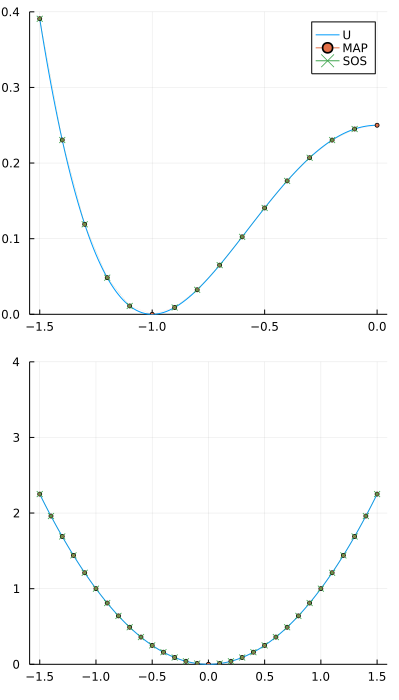

In [69]:
plt = plot(plot(ylim=(0.0,0.4)), plot(ylim=(0.0,4.0), legend=false), layout = @layout([a; b]), size=(400,700))

xVec = collect(-1.5:0.1:0.0)
Us = xi->coefficients(subs(U,x[1]=>xi,x[2]=>x₀[2]))[1] - coefficients(subs(U,x[1]=>x₀[1],x[2]=>x₀[2]))[1]
plot!(plt[1], collect(xVec[1]:0.01:xVec[end]),Us, label="U")
plot!(plt[1], xVec,Smx, line=0, marker=3, label="MAP")
plot!(plt[1], xVec,Ssx, line=0, marker=(3,:x), label="SOS")

xVec = collect(-1.5:0.1:1.5)
Us = xi->coefficients(subs(U,x[1]=>x₀[1],x[2]=>xi))[1] - coefficients(subs(U,x[1]=>x₀[1],x[2]=>x₀[2]))[1]
plot!(plt[2], collect(xVec[1]:0.01:xVec[end]),Us, label="U")
plot!(plt[2], xVec,Smy, line=0, marker=(3), label="MAP")
plot!(plt[2], xVec,Ssy, line=0, marker=(3,:x), label="SOS")